In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

%matplotlib inline


import warnings 
warnings.filterwarnings('ignore')

In [21]:
data=pd.read_csv("Algerian_forest_fires_update_dataset.csv")

In [22]:
data.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

## Drop day, month and year column

In [23]:
data.drop(['day', 'month', 'year'], axis = 1, inplace=True)

In [24]:
data.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [25]:
data['Classes'].value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

In [26]:
data['Classes'] = data['Classes'].str.strip()
data['Classes'].value_counts()

Classes
fire        137
not fire    106
Name: count, dtype: int64

<Axes: >

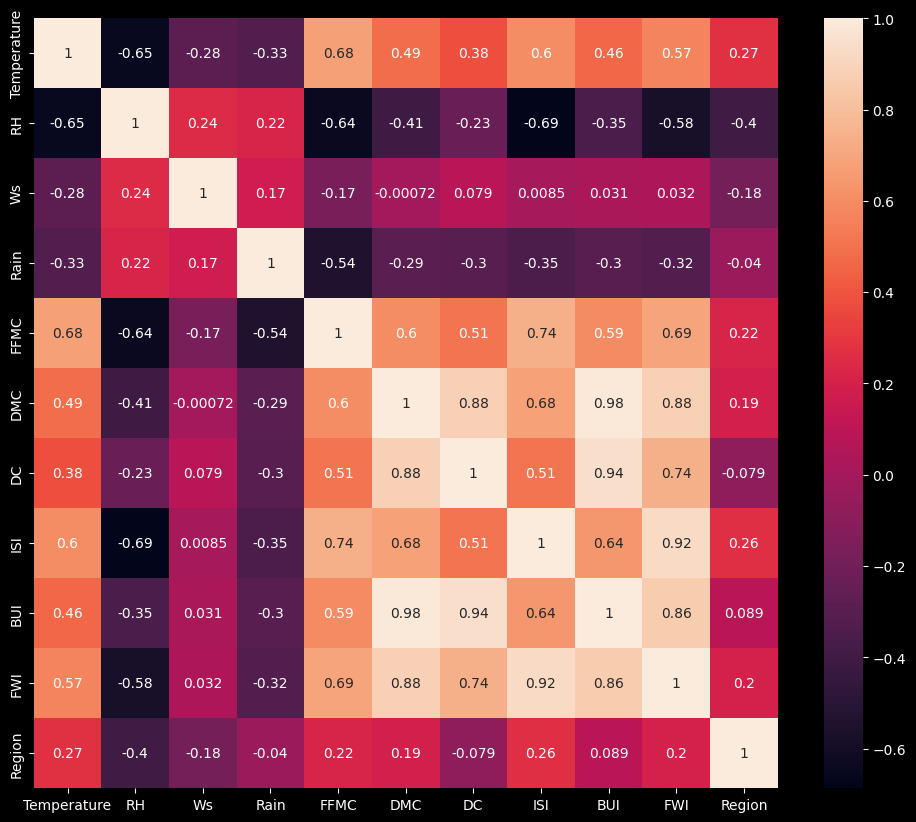

In [27]:
numeric_c = data.select_dtypes(exclude='object')
plt.figure(figsize=(12,10))
corr = numeric_c.corr()
sns.heatmap(corr, annot=True)

In [28]:
def correlation(dataset, threshold):
    col_corr =set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]>threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [29]:
corr_features = correlation(numeric_c, 0.85)

In [30]:
corr_features

{'BUI', 'DC', 'FWI'}

In [31]:
data = data.drop('DC', axis=1)

## Feature Engineering

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split

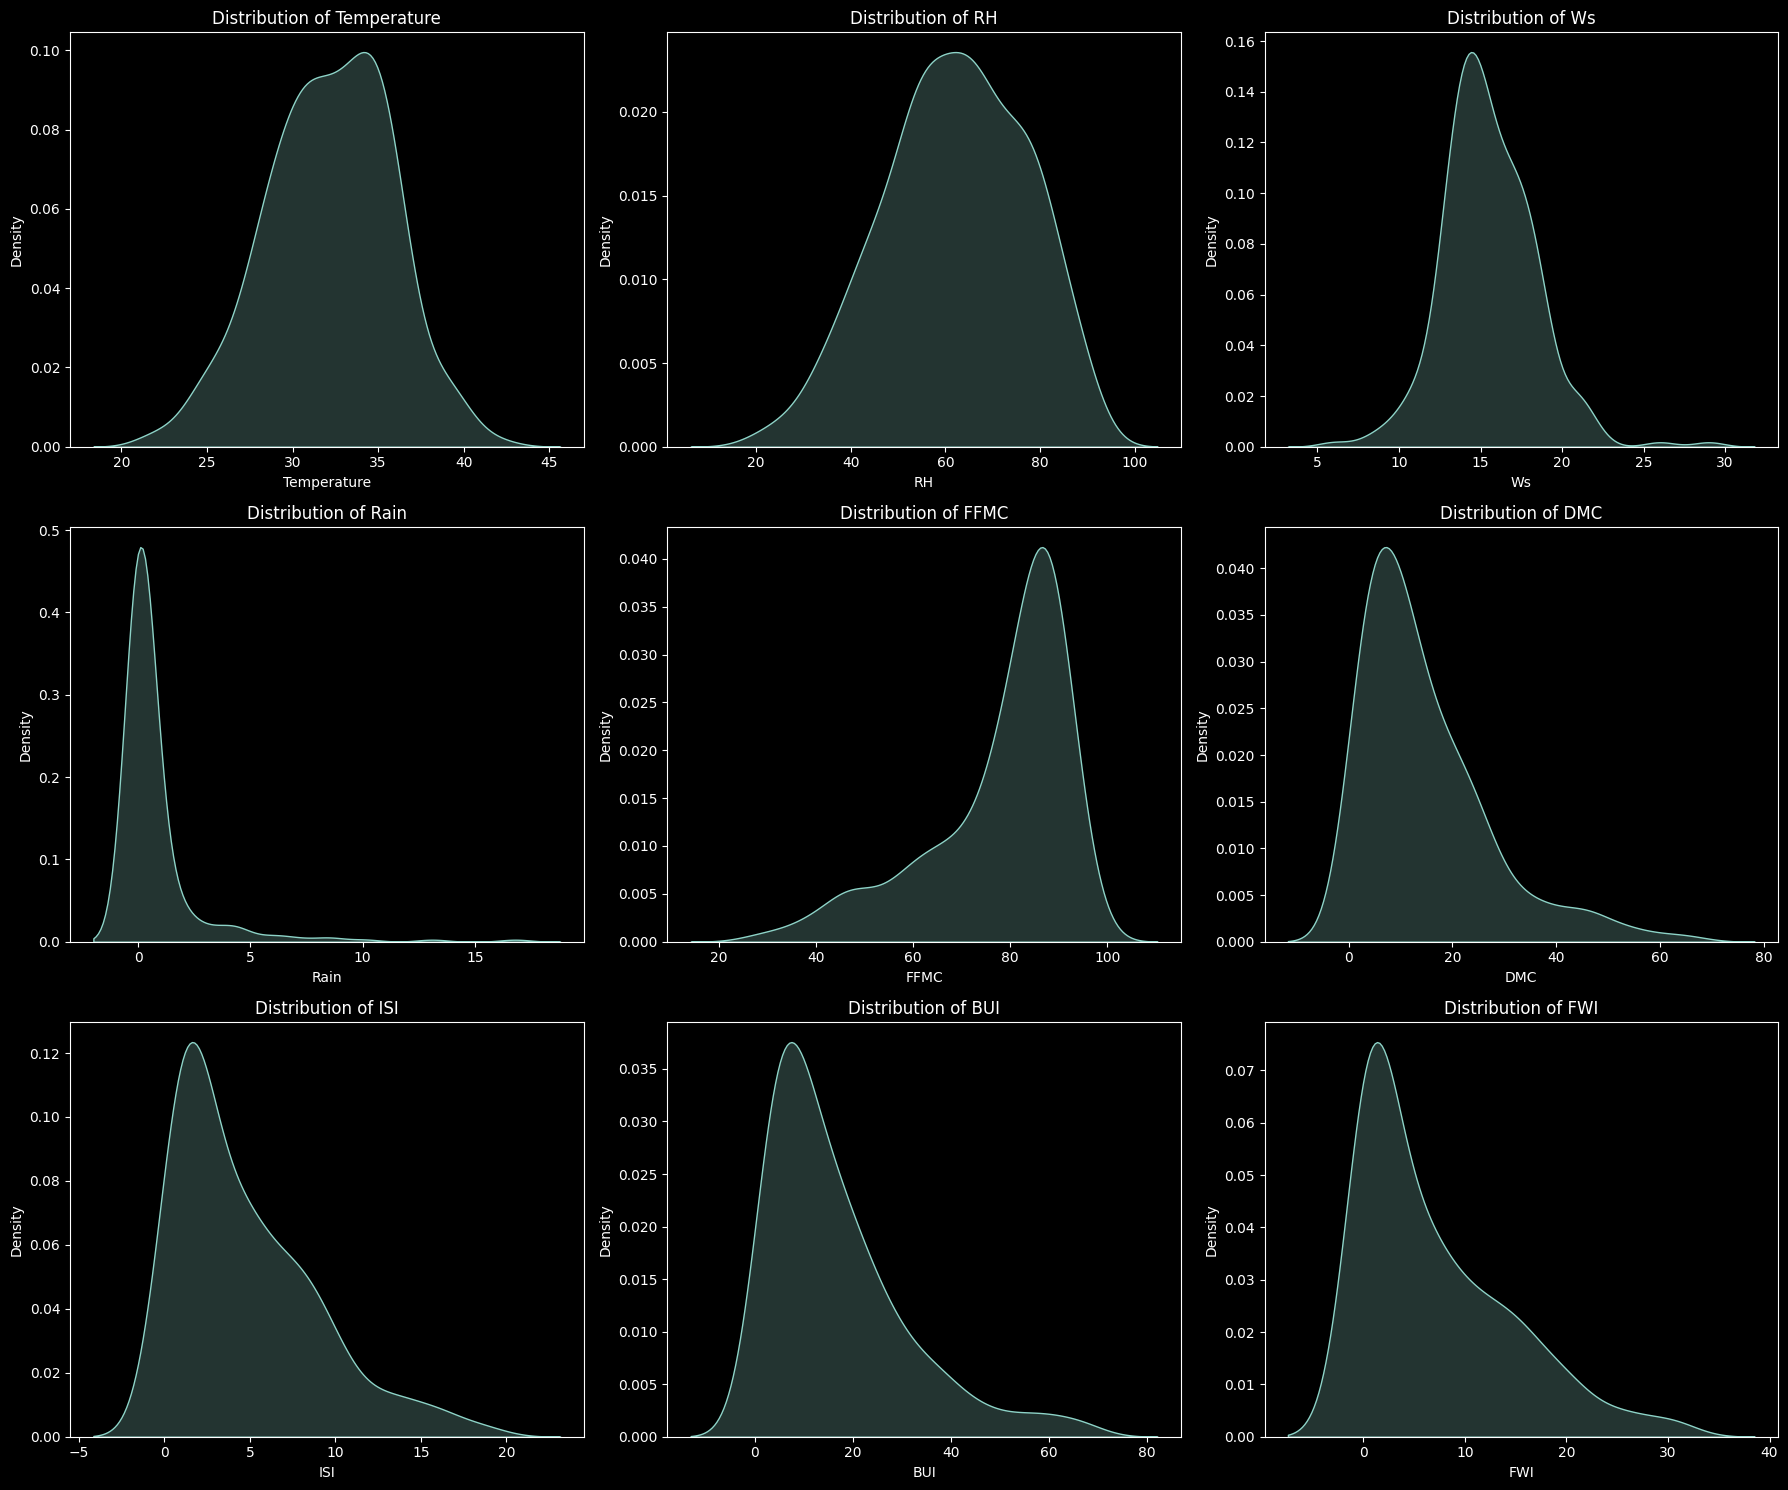

In [33]:
columns_to_plot = [
    'Temperature', 'RH', 'Ws', 'Rain', 
    'FFMC', 'DMC', 'ISI', 'BUI', 'FWI'
]

df_to_plot = data[columns_to_plot]

n_cols = 3  
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, 
                         figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(columns_to_plot):
    sns.kdeplot(data=df_to_plot, x=col_name, ax=axes[i], fill=True)
    axes[i].set_title(f'Distribution of {col_name}', fontsize=12)
    axes[i].set_xlabel(col_name, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)

for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])
plt.tight_layout()

In [34]:
data

,Temperature,RH,Ws,Rain,FFMC,DMC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,1.2,3.9,0.5,not fire,0
...,...,...,...,...,...,...,...,...,...,...,...
238,30,65,14,0.0,85.4,16.0,4.5,16.9,6.5,fire,1
239,28,87,15,4.4,41.1,6.5,0.1,6.2,0.0,not fire,1
240,27,87,29,0.5,45.9,3.5,0.4,3.4,0.2,not fire,1
241,24,54,18,0.1,79.7,4.3,1.7,5.1,0.7,not fire,1


In [35]:
X = data.drop(columns=['FWI'], axis=1)
y = data['FWI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.2,
    random_state=42
)

In [36]:
skewed_cols = ['Rain', 'FFMC', 'DMC', 'ISI', 'BUI']
unskewed_numeric_cols = ['Temperature', 'RH', 'Ws', 'Region']
categorical_cols = ['Classes']

skewed_numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transform', PowerTransformer(method='yeo-johnson'))
])

unskewed_numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categoric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(categories=[['not fire', 'fire']]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('skewed', skewed_numeric_pipe, skewed_cols),
        ('unskewed', unskewed_numeric_pipe, unskewed_numeric_cols),
        ('catcol', categoric_pipe, categorical_cols)
    ],
    remainder='passthrough'
)

In [40]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## Storing models to a dictionary
models = {
    'LinearReg': LinearRegression(),
    'Lasso': Lasso(),
    'LassoCV': LassoCV(),
    'Ridge': Ridge(),
    'RidgeCV': RidgeCV(),
    'ElasticNet': ElasticNet()
}

for name, model in models.items():

    print(f"\n===== Training {name} =====")

    ## a pipeline combining preprocessing and the model
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("classifier", model)
    ])

    ## train the model
    pipeline.fit(X_train, y_train)

    ## predictions for training and test sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    ## training performance
    model_train_r2 = r2_score(y_train, y_train_pred)
    model_train_mae = mean_absolute_error(y_train, y_train_pred)

    # test performance
    model_test_r2 = r2_score(y_test, y_test_pred)
    model_test_mae = mean_absolute_error(y_test, y_test_pred)

    print("\nModel performance for Training Set")
    print(f" - r2 Score:{model_train_r2:.4f}")
    print(f" - Mean Absolute Error:{model_train_mae:.4f}")

    print("\nModel performance for Test Set")
    print(f" - r2 Score:{model_test_r2:.4f}")
    print(f" - Mean Absolute Error:{model_test_mae:.4f}")

    print("=" * 40)



===== Training LinearReg =====

Model performance for Training Set
 - r2 Score:0.9406
 - Mean Absolute Error:1.2644

Model performance for Test Set
 - r2 Score:0.8806
 - Mean Absolute Error:1.8838

===== Training Lasso =====

Model performance for Training Set
 - r2 Score:0.8494
 - Mean Absolute Error:1.9825

Model performance for Test Set
 - r2 Score:0.7709
 - Mean Absolute Error:2.6670

===== Training LassoCV =====

Model performance for Training Set
 - r2 Score:0.9388
 - Mean Absolute Error:1.2689

Model performance for Test Set
 - r2 Score:0.8755
 - Mean Absolute Error:1.8899

===== Training Ridge =====

Model performance for Training Set
 - r2 Score:0.9195
 - Mean Absolute Error:1.4468

Model performance for Test Set
 - r2 Score:0.8318
 - Mean Absolute Error:2.3171

===== Training RidgeCV =====

Model performance for Training Set
 - r2 Score:0.9393
 - Mean Absolute Error:1.2654

Model performance for Test Set
 - r2 Score:0.8723
 - Mean Absolute Error:1.9431

===== Training Elasti

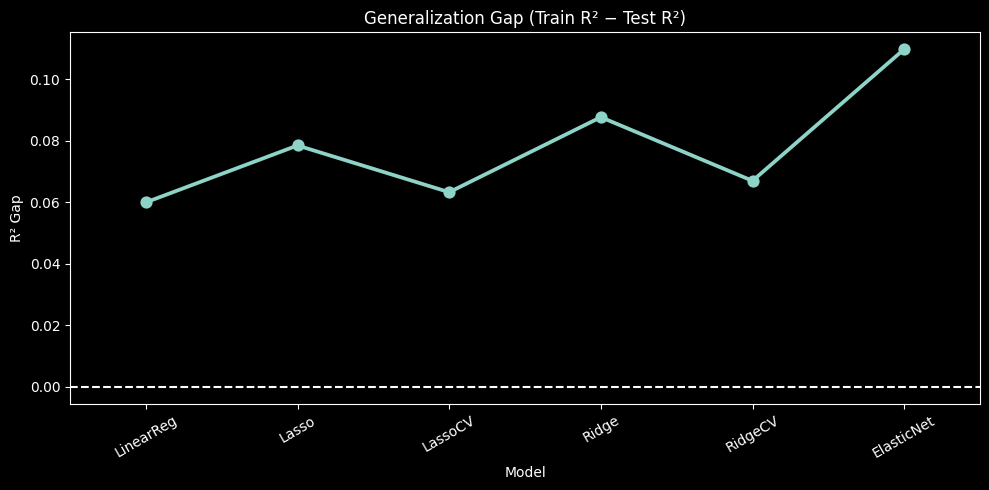

In [41]:
results = pd.DataFrame({
    "Model": [
        "LinearReg", "Lasso", "LassoCV",
        "Ridge", "RidgeCV", "ElasticNet"
    ],
    "Train_R2": [0.9406, 0.8494, 0.9388, 0.9195, 0.9393, 0.8189],
    "Test_R2":  [0.8806, 0.7709, 0.8755, 0.8318, 0.8723, 0.7091],
})

results["R2_Gap"] = results["Train_R2"] - results["Test_R2"]

plt.figure(figsize=(10,5))
sns.pointplot(
    data=results,
    x="Model",
    y="R2_Gap"
)

plt.axhline(0, linestyle="--")
plt.title("Generalization Gap (Train R² − Test R²)")
plt.ylabel("R² Gap")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [42]:
## Checking for cross validation score for the models

from sklearn.model_selection import cross_val_score

cv_results = {}

for name, model in models.items():

    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("regressor", model)
    ])

    # 5-fold cross validation using R2
    cv_scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring="r2",
        n_jobs=-1
    )

    cv_results[name] = cv_scores

    print(f"\n{name}")
    print(f"CV R2 scores : {np.round(cv_scores, 4)}")
    print(f"Mean CV R2   : {cv_scores.mean():.4f}")
    print(f"Std CV R2    : {cv_scores.std():.4f}")


LinearReg
CV R2 scores : [0.8888 0.8504 0.9015 0.8632 0.7669]
Mean CV R2   : 0.8542
Std CV R2    : 0.0472

Lasso
CV R2 scores : [0.7961 0.5287 0.8125 0.9264 0.8472]
Mean CV R2   : 0.7822
Std CV R2    : 0.1344

LassoCV
CV R2 scores : [0.9018 0.8323 0.9123 0.8809 0.7524]
Mean CV R2   : 0.8559
Std CV R2    : 0.0586

Ridge
CV R2 scores : [0.8036 0.7511 0.8788 0.9432 0.732 ]
Mean CV R2   : 0.8217
Std CV R2    : 0.0792

RidgeCV
CV R2 scores : [0.8869 0.8287 0.913  0.8923 0.7611]
Mean CV R2   : 0.8564
Std CV R2    : 0.0553

ElasticNet
CV R2 scores : [0.6628 0.5269 0.7383 0.9329 0.8371]
Mean CV R2   : 0.7396
Std CV R2    : 0.1400


In [ ]:
models = {
    "LinearReg": {
        "model": LinearRegression(),
        "params": {
            "classifier__fit_intercept": [True, False],
            "classifier__positive": [True, False]
        }
    },
    "LassoCV": LassoCV(
        alphas=[0.0001, 0.001, 0.01, 0.1, 1],
        cv=5,
        max_iter=10000
    ),
    "RidgeCV": RidgeCV(
        alphas=[0.01, 0.1, 1, 10, 100],
        cv=5
    )
}

## Box PLot to understand the effect of standard scaling

NameError: name 'X_train_scaled' is not defined

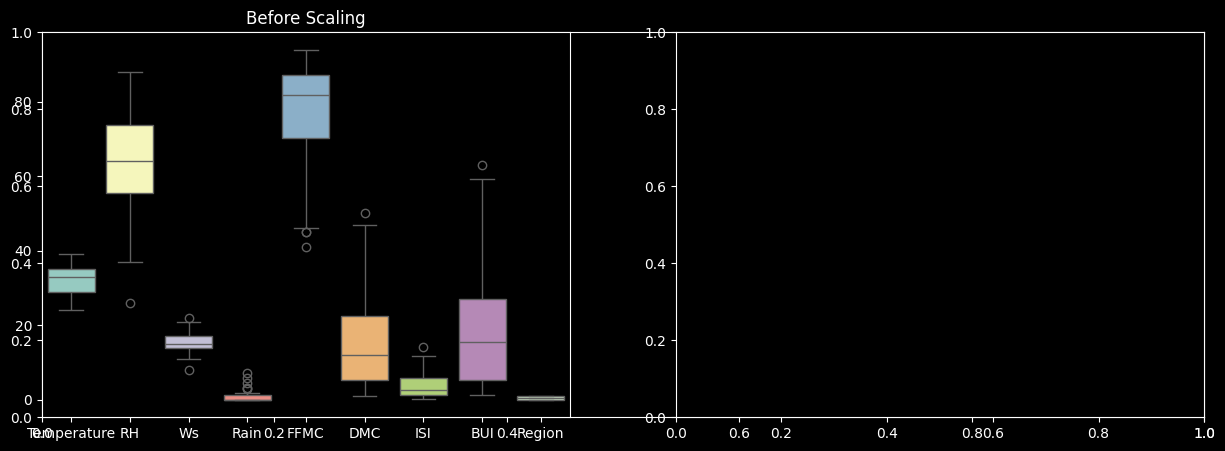

In [38]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title("Before Scaling")
plt.subplot(1,2,2)
sns.boxplot(data=X_train_scaled)
plt.title("After Scaling")

## Linear Regression

Mean absolute error 0.5468236465249977
R2 score 0.9847657384266951


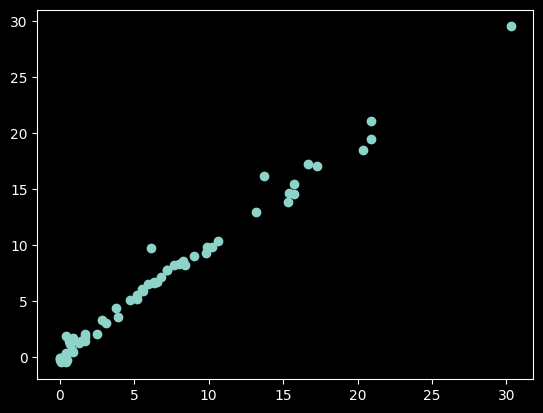

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

linear = LinearRegression()
linear.fit(X_train_scaled, y_train)
y_pred = linear.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("Mean absolute error", mae)
print("R2 score", score)
plt.scatter(y_test, y_pred)

## Lasso

Mean absolute error 1.1331759949144085
R2 score 0.9492020263112388


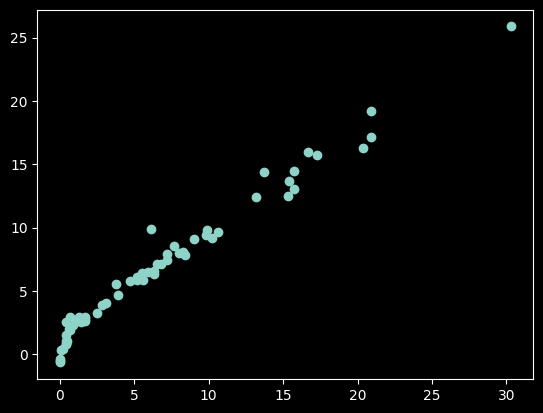

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

lasso = Lasso()
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("Mean absolute error", mae)
print("R2 score", score)
plt.scatter(y_test, y_pred)

## Cross Validation Lasso

In [ ]:
from sklearn.linear_model import LassoCV
la = LassoCV(cv=5)
la.fit(X_train_scaled, y_train)

LassoCV(cv=5)

Mean Absolute error 0.6199701158263433
R2 Score 0.9820946715928275


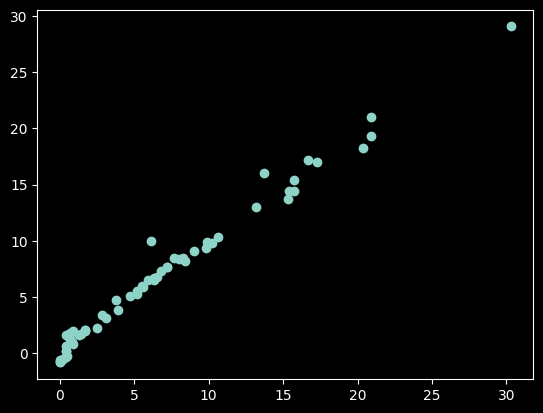

In [ ]:
y_pred = la.predict(X_test_scaled)
plt.scatter(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)
print("Mean Absolute error", mae)
print("R2 Score", score)

## Ridge Regression model

Mean Absolute error 0.5642305340105715
R2 Score 0.9834070933284211


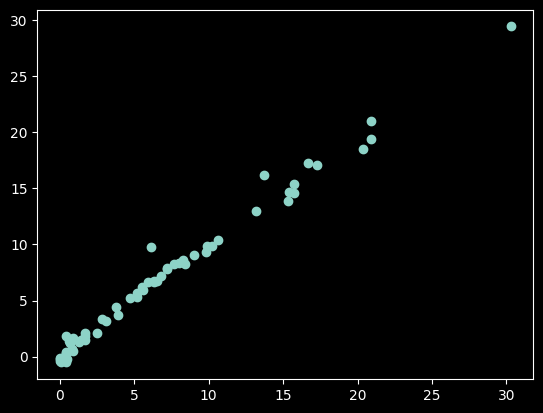

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r = Ridge()
r.fit(X_train_scaled, y_train)
y_pred = r.predict(X_test_scaled)
mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)
plt.scatter(y_test, y_pred)

In [ ]:
from sklearn.linear_model import RidgeCV
rc = RidgeCV(cv=5)
rc.fit(X_train_scaled, y_train)
y_pred = rc.predict(X_test_scaled)
print("Mean Absolute error", mae)
print("R2 Score", score)

Mean Absolute error 0.5642305340105715
R2 Score 0.9834070933284211


In [ ]:
rc.get_params()

{'alpha_per_target': False,
 'alphas': (0.1, 1.0, 10.0),
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_results': None,
 'store_cv_values': 'deprecated'}

## Elasticnet Regression

Mean Absolute error 1.8822353634896
R2 Score 0.7814447243400926


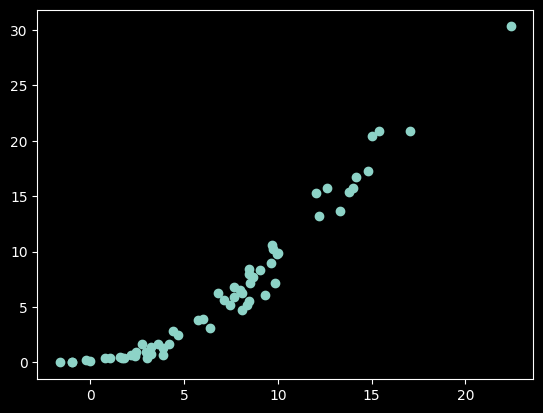

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

el = ElasticNet()

el.fit(X_train_scaled, y_train)
y_pred = el.predict(X_test_scaled)

plt.scatter(y_pred, y_test)

mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)

Mean Absolute error 0.6575946731430904
R2 Score 0.9799084998743879


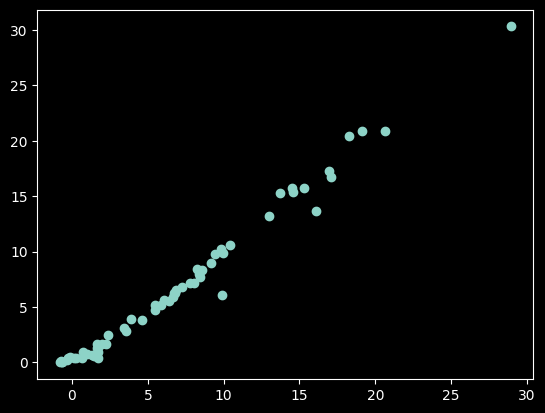

In [ ]:
from sklearn.linear_model import ElasticNetCV
e = ElasticNetCV(cv=5)

e.fit(X_train_scaled, y_train)
y_pred = e.predict(X_test_scaled)

plt.scatter(y_pred, y_test)

mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)

## Pickle the machine learning models, preprocessing model standardscaler

In [ ]:
standard

StandardScaler()

In [ ]:
r

Ridge()

In [ ]:
import joblib

joblib.dump(standard, "scaler.pkl")
joblib.dump(r, "ridge.pkl")


['ridge.pkl']